In [1]:
import os
import io
import en_core_web_lg


import pandas as pd 
import tensorflow as tf 
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from spacy.lang.en.stop_words import STOP_WORDS

nlp = en_core_web_lg.load()

In [2]:
df = pd.read_csv('spam.csv', encoding="ISO-8859-1")

In [3]:
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [4]:
display(100*df.isnull().sum()/df.shape[0])

v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

In [5]:
df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)

In [6]:
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [7]:
df["review_clean"] = df["v2"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
df["review_clean"] = df["review_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
df["review_clean"] = df["review_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))
df["len_review"] = df["review_clean"].apply(lambda x: len(x))
df["target"] = df["v1"].apply(lambda x: 1 if x == "ham" else 0)
df

,v1,v2,review_clean,len_review,target
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,75,1
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,21,1
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,129,0
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,19,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,18,1
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,2nd time try 2 contact u u win å750 pound priz...,104,0
5568,ham,Will Ì_ b going to esplanade fr home?,ì b esplanade fr home,21,1
5569,ham,"Pity, * was in mood for that. So...any other s...",pity mood soany suggestion,28,1
5570,ham,The guy did some bitching but I acted like i'd...,guy bitching act like interested buy week free,46,1


In [8]:
display(100*df.isnull().sum()/df.shape[0])

v1              0.0
v2              0.0
review_clean    0.0
len_review      0.0
target          0.0
dtype: float64

<AxesSubplot: >

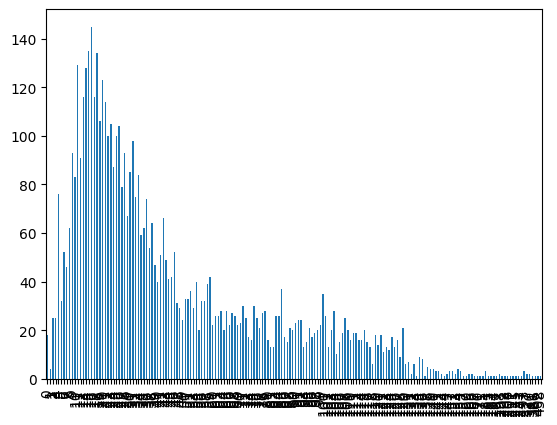

In [9]:
df['len_review'].value_counts().sort_index().plot(kind='bar')

In [10]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000) 
tokenizer.fit_on_texts(df["review_clean"])
df["review_encoded"] = tokenizer.texts_to_sequences(df["review_clean"])

In [11]:
reviews_pad = tf.keras.preprocessing.sequence.pad_sequences(df["review_encoded"], padding="post")

xtrain, xval, ytrain, yval = train_test_split(reviews_pad,df["target"], test_size=0.3)

train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [12]:
for review, star in train_batch.take(1):
  print(review, star)

tf.Tensor(
[[277  85  52 ...   0   0   0]
 [695 178 128 ...   0   0   0]
 [ 55 403  19 ...   0   0   0]
 ...
 [186 364 135 ...   0   0   0]
 [  5 122   0 ...   0   0   0]
 [522 443  38 ...   0   0   0]], shape=(64, 54), dtype=int32) tf.Tensor(
[1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1
 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1], shape=(64,), dtype=int64)


In [13]:
vocab_size = len(tokenizer.word_index)
model = tf.keras.Sequential([             
            tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=[review.shape[1],],name="embedding"),  
            tf.keras.layers.GlobalAveragePooling1D(),    
            tf.keras.layers.Dense(16, activation='relu'),      
            tf.keras.layers.Dense(1, activation="sigmoid")
                ])

tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [27]:
optimizer= tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 54, 8)             65528     
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 65,689
Trainable params: 65,689
Non-trainable params: 0
_________________________________________________________________


In [29]:
history = model.fit(train_batch, 
                    epochs=12, 
                    validation_data=val_batch)

Epoch 1/12
61/61 [==============================] - 1s 3ms/step - loss: 0.1189 - accuracy: 0.9654 - val_loss: 0.1320 - val_accuracy: 0.9581
Epoch 2/12
61/61 [==============================] - 0s 2ms/step - loss: 0.1008 - accuracy: 0.9733 - val_loss: 0.1189 - val_accuracy: 0.9623
Epoch 3/12
61/61 [==============================] - 0s 2ms/step - loss: 0.0875 - accuracy: 0.9774 - val_loss: 0.1073 - val_accuracy: 0.9665
Epoch 4/12
61/61 [==============================] - 0s 2ms/step - loss: 0.0770 - accuracy: 0.9795 - val_loss: 0.1011 - val_accuracy: 0.9689
Epoch 5/12
61/61 [==============================] - 0s 2ms/step - loss: 0.0691 - accuracy: 0.9803 - val_loss: 0.0926 - val_accuracy: 0.9713
Epoch 6/12
61/61 [==============================] - 0s 2ms/step - loss: 0.0628 - accuracy: 0.9828 - val_loss: 0.0893 - val_accuracy: 0.9713
Epoch 7/12
61/61 [==============================] - 0s 2ms/step - loss: 0.0580 - accuracy: 0.9831 - val_loss: 0.0841 - val_accuracy: 0.9749
Epoch 8/12
61/61 [==

In [30]:
model_loss = pd.DataFrame(model.history.history)
model_loss

,loss,accuracy,val_loss,val_accuracy
0,0.118914,0.965385,0.132008,0.958134
1,0.100818,0.973333,0.118911,0.962321
2,0.087508,0.977436,0.107263,0.966507
3,0.077033,0.979487,0.101126,0.968900
4,0.069110,0.980256,0.092615,0.971292
5,0.062847,0.982821,0.089265,0.971292
6,0.058039,0.983077,0.084092,0.974880
7,0.053909,0.983846,0.081038,0.974880
8,0.050561,0.983846,0.078159,0.976077
9,0.047601,0.984872,0.075873,0.976077


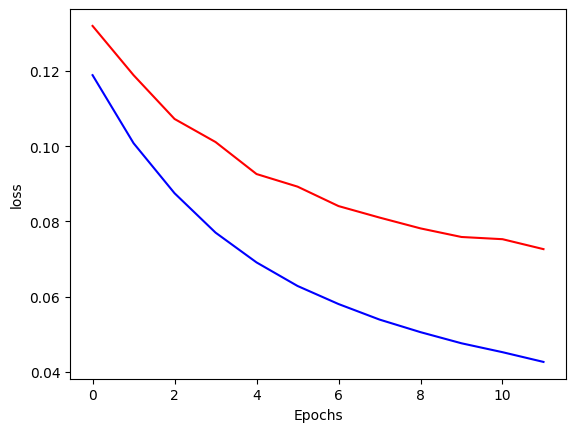

In [33]:
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

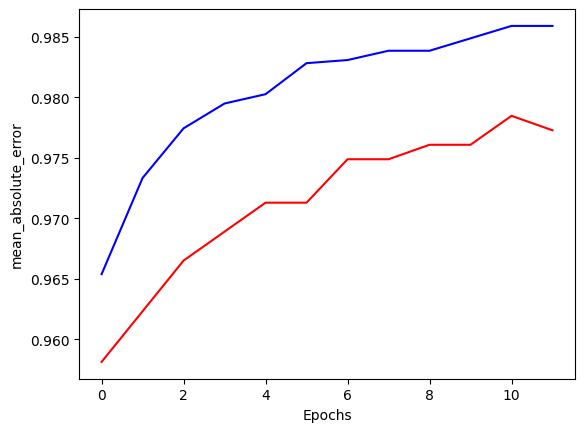

In [32]:
plt.plot(history.history["accuracy"], color="b")
plt.plot(history.history["val_accuracy"], color="r")
plt.ylabel("mean_absolute_error")
plt.xlabel("Epochs")
plt.show()

In [20]:
pred = model.predict(x=xval)

53/53 [==============================] - 0s 539us/step
